In [1]:
import numpy as np
import astropy.units as au
import astropy.constants.si as ac
from tvolib import mpl_utils as mu

from rls.simulation import Simulation
from rls.data_types import SimQuantity, Particle
from rls.formula.physics import lorentz_factor
from rls.formula.conversions import energy_to_speed, cartesian_to_FAC
from rls.models import WhistlerAtGradientModel


def plot_diagnostics(model, solutions):
    units = model.units
    c = units.c.code
    R = model.R.code
    B0 = model.B0.code
    Bw = model.Bw.code
    w_wce = model.w_wce
    theta = model.theta
    sw = model.sw.code
    qe = units.electron.q.code
    me = units.electron.m.code
    wpe0 = units.electron.wp(model.n0, units.eps0).code
    wce0 = units.electron.wc(model.B0).code
    V_factor = (units.L_factor / units.T_factor).to("1000 km/s").user
    W_factor = units.W_factor.user

    t = solutions.t
    g, x, y, z, ux, uy, uz = solutions.as_tuple() 
    tg = t[:, np.newaxis] * np.ones_like(x)

    _, _, _, B0_x, _, B0_z = model.background_field(
        tg, x, y, z, *model.background_field_args
    )
    wce = np.abs(qe * np.sqrt(B0_x**2 + B0_z**2) / me)
    w, k = model.dispersion_relation(wce, w_wce, wpe0, c)
    V_para, V_perp, W, A = cartesian_to_FAC(g, ux, uy, uz, B0_x, B0_z, model)
    W0 = W[0, :]
    dW = W - W0[np.newaxis, :]
    particle_colors = mu.plt.cm.jet(np.linspace(0, 1, Np := W0.size))

    # ---- Velocity space
    fig, ax = mu.plt.subplots(1, 1, figsize=(8, 6))

    for ip in range(Np):
        ax.plot(
            V_para[:, ip].user.value,
            V_perp[:, ip].user.value,
            c=particle_colors[ip]
        )

    ax.scatter(
        V_para[0, :].user.value,
        V_perp[0, :].user.value,
        fc="w", ec="k", s=20, zorder=9
    )
    
    V_perp_arr = np.linspace(0, 0.03, 1000) * c
    colors = ["r", "k", "b"]
    for i, _z in enumerate([-3.0 * R, 0.0, 3.0 * R]):
        _wce = np.abs(qe * B0 / me) * model.eta(_z, *model.background_field_args)
        _w, _k = model.dispersion_relation(_wce, w_wce, wpe0, c)
        _Vr = np.cos(theta) * model.resonant_velocity(_wce, w_wce, wpe0, c)
        _dV = model.resonant_width(V_perp_arr, Bw, B0, _wce, w_wce, wpe0, c)
        ax.plot((_Vr + _dV) * V_factor, V_perp_arr * V_factor, c=colors[i])
        ax.plot((_Vr - _dV) * V_factor, V_perp_arr * V_factor, c=colors[i])
    
    ax.set_aspect("equal")
    ax.set_facecolor("silver")
    #ax.set_xlim(-20, 20)
    #ax.set_ylim(0, 20)
    fig.tight_layout()

    # ---- Phase space
    fig, axes = mu.plt.subplots(5, 1, sharex=True, figsize=(12, 10))

    dt = np.diff(t).mean()
    Ew_x, Ew_y, Ew_z, _, _, _ = model.field(tg, x, y, z, *model.field_args)
    P_int = np.cumsum(qe * (Ew_x * ux + Ew_y * uy + Ew_z * uz) * dt, axis=0) * W_factor.value
    for ip in range(Np):
        axes[1].plot(z[:, ip] / R, V_para[:, ip].user.value, c=particle_colors[ip])
        axes[2].plot(z[:, ip] / R, A[:, ip].user.value, c=particle_colors[ip])
        axes[3].plot(z[:, ip] / R, dW[:, ip].user.value, c=particle_colors[ip])
        axes[4].plot(z[:, ip] / R, P_int[:, ip], c=particle_colors[ip])

    kw = dict(fc="w", ec="k", s=20, zorder=9)
    axes[1].scatter(z[0, :] / R, V_para[0, :].user.value, **kw)
    axes[2].scatter(z[0, :] / R, A[0, :].user.value, **kw)
    axes[3].scatter(z[0, :] / R, dW[0, :].user.value, **kw)
    axes[3].scatter(z[0, :] / R, P_int[0, :], **kw)

    z_arr = np.linspace(-3 * R, 3 * R, 1000)
    B0_z_arr = B0 * model.eta(z_arr, *model.background_field_args)
    wce_arr = np.abs(qe * B0_z_arr / me)
    Vr_arr = model.resonant_velocity(wce_arr, w_wce, wpe0, c) * V_factor
    trap_angle = np.degrees(np.arcsin(np.sqrt(B0_z_arr / B0)))
    axes[0].plot(z_arr / R, B0_z_arr, "-k")
    axes[1].plot(z_arr / R, Vr_arr, "--k", lw=2)
    axes[2].plot(z_arr / R, trap_angle, "--k", lw=2)
    axes[2].plot(z_arr / R, 180 - trap_angle, "--k", lw=2)

    axes[0].set_ylabel("$B_{0z}$")
    axes[1].set_ylabel("$V_\|$")
    axes[2].set_ylabel("$\\alpha$ (deg)")
    axes[3].set_ylabel("$\\Delta W$ (eV)")
    axes[4].set_ylabel("$\\int Pdt$ (eV)")
    for (i, ax) in enumerate(axes):
        ax.set_xlim(z_arr[0] / R, z_arr[-1] / R)
        if i >= 1:
            ax.set_facecolor("silver")
        if i == len(axes) - 1:
            ax.set_xlabel("$z/R$")
        
    fig.tight_layout(h_pad=0.05)

    mu.plt.show()

In [6]:
sim = Simulation(model=WhistlerAtGradientModel(
    Bw=0.05, w_wce=0.05, sw=1.75, Bh=-0.8, B0=-1.0
))
model = sim.model
units = model.units
V_factor = (units.L_factor / units.T_factor)
W_factor = units.W_factor

W_para_min = 1 * au.eV
W_para_min = SimQuantity(W_factor.user_to_code(W_para_min), W_para_min)
V_para_min = energy_to_speed(W_para_min, units)

W_para_max = 1000 * au.eV
W_para_max = SimQuantity(W_factor.user_to_code(W_para_max), W_para_max)
V_para_max = energy_to_speed(W_para_max, units)

W_perp = 1 * au.eV
W_perp = SimQuantity(W_factor.user_to_code(W_perp), W_perp)
V_perp = energy_to_speed(W_perp, units)

Pushed 0/200000 steps (0.00%, 0.000000 ms/step, estimated remaining run time = 0.00 min)
Pushed 20000/200000 steps (10.00%, 0.000020 ms/step, estimated remaining run time = 0.06 min)
Pushed 40000/200000 steps (20.00%, 0.000020 ms/step, estimated remaining run time = 0.05 min)
Pushed 60000/200000 steps (30.00%, 0.000020 ms/step, estimated remaining run time = 0.05 min)
Pushed 80000/200000 steps (40.00%, 0.000020 ms/step, estimated remaining run time = 0.04 min)
Pushed 100000/200000 steps (50.00%, 0.000020 ms/step, estimated remaining run time = 0.03 min)
Pushed 120000/200000 steps (60.00%, 0.000022 ms/step, estimated remaining run time = 0.03 min)
Pushed 140000/200000 steps (70.00%, 0.000021 ms/step, estimated remaining run time = 0.02 min)
Pushed 160000/200000 steps (80.00%, 0.000021 ms/step, estimated remaining run time = 0.01 min)
Pushed 180000/200000 steps (90.00%, 0.000021 ms/step, estimated remaining run time = 0.01 min)
Done!


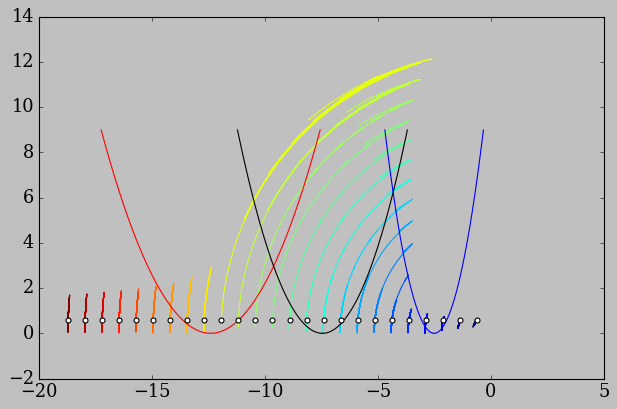

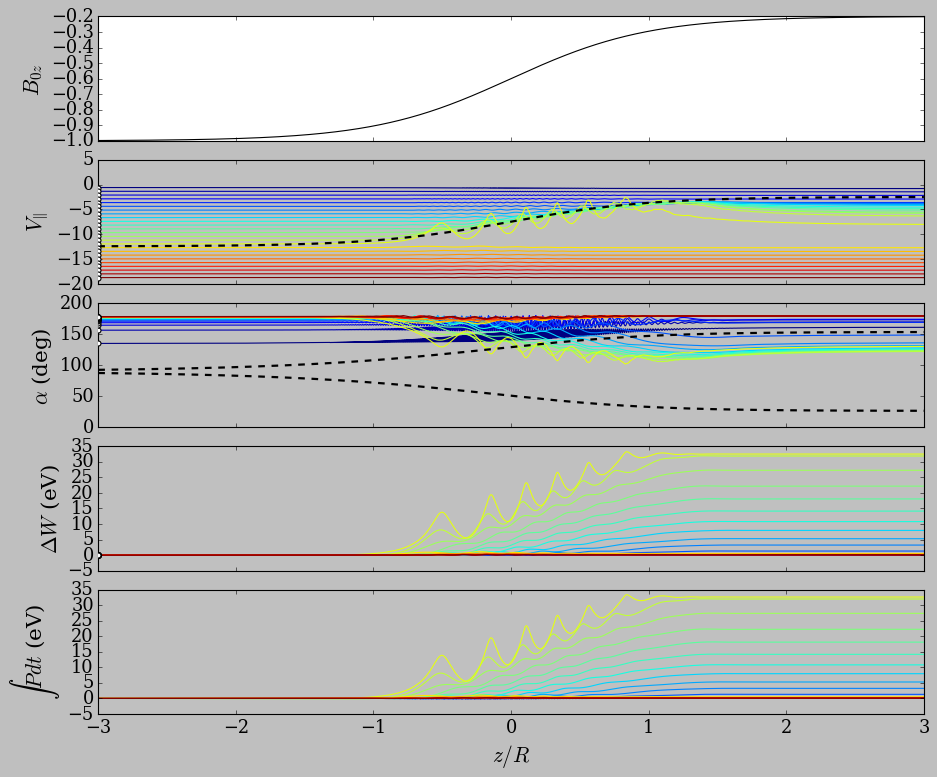

In [7]:
model.theta = 0.0
c = units.c.code
R = model.R.code
Tc = units.electron.Tc(model.B0).code

uz0 = np.linspace(V_para_min.code, V_para_max.code, 25)
ux0 = np.zeros_like(uz0) + V_perp.code
uy0 = np.zeros_like(uz0)
x0 = np.zeros_like(uz0)
y0 = np.zeros_like(uz0)
z0 = np.zeros_like(uz0) - 3.0 * R
g0 = lorentz_factor(ux0, uy0, uz0, c)
ICs = Particle(units.electron, 0.0, g0, x0, y0, z0, ux0, uy0, uz0)
sim.run(
    initial_conditions=ICs,
    run_time=2000.0 * Tc,
    step_size=1e-2 * Tc,
    save_intervals=-1,
    log_intervals=10,
)
plot_diagnostics(model, sim.solutions)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
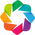

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [4]:
import numpy as np, pandas as pd, datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
import holoviews as hv
from holoviews.operation.datashader import datashade, dynspread

hv.extension('bokeh')

c = units.c.code
R = model.R.code
B0 = model.B0.code
Bw = model.Bw.code
w_wce = model.w_wce
theta = model.theta
sw = model.sw.code
qe = units.electron.q.code
me = units.electron.m.code
wpe0 = units.electron.wp(model.n0, units.eps0).code
wce0 = units.electron.wc(model.B0).code

t = sim.solutions.t
g, x, y, z, ux, uy, uz = sim.solutions.as_tuple() 
tg = t[:, np.newaxis] * np.ones_like(x)

_, _, _, B0_x, _, B0_z = model.background_field(
    tg, x, y, z, *model.background_field_args
)
B0_mag = np.sqrt(B0_x**2 + B0_z**2)
wce = np.abs(qe * np.sqrt(B0_x**2 + B0_z**2) / me)
w, k = model.dispersion_relation(wce, w_wce, wpe0, c)
kx = k * (B0_x * np.cos(theta) - B0_z * np.sin(theta)) / B0_mag
kz = k * (B0_x * np.sin(theta) + B0_z * np.cos(theta)) / B0_mag
phase = (kx * x + kz * z - w * tg) % (2 * np.pi)
phi = np.arctan2(uy - x, ux)
V_para, V_perp, W, A = cartesian_to_FAC(g, ux, uy, uz, B0_x, B0_z, model)


idx = np.isclose(z, 0.0, atol=R) & np.isclose(phase, np.pi / 2, atol=0.1)

df = pd.DataFrame(dict(x=ux[idx], y=uy[idx]))

# agg = cvs.points(df, 'x', 'y')
# ds.transfer_functions.Image.border=0
# tf.shade(agg, cmap = ["white", "black"])

dynspread(
    datashade(
        hv.Points(df),
        cmap=viridis[::-1]
    ).opts(width=800,height=600)
)